In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection
from numpy.random import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
#load data
path = '/Users/dankang/Desktop/SpringBoard/Spotify/Data/Processed Data/EDA_Spotify_Data.csv'
df = pd.read_csv(path)

In [3]:
#median pop -drawdown and discuss metric
key_features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence', 'year', 'median popularity']
df1 = df[key_features]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns='popularity'), 
                                                    df1.popularity, test_size=0.2, 
                                                    random_state=47)

In [5]:
X_train.describe()

,acousticness,danceability,energy,instrumentalness,liveness,valence,year,median popularity
count,106910.000000,106910.000000,106910.000000,106910.000000,106910.000000,106910.000000,106910.000000,106910.000000
mean,0.503016,0.538626,0.483317,0.168756,0.210545,0.533016,1975.844364,30.018492
std,0.378125,0.177638,0.268224,0.314406,0.179692,0.263611,26.289269,21.024161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000,0.000000
25%,0.100000,0.415000,0.255000,0.000000,0.099400,0.324000,1954.000000,9.000000
50%,0.515000,0.550000,0.472000,0.000235,0.138000,0.546000,1977.000000,33.000000
75%,0.900000,0.672000,0.705000,0.111000,0.270000,0.751000,1998.000000,46.000000
max,0.996000,0.988000,1.000000,1.000000,1.000000,1.000000,2020.000000,100.000000


In [6]:
#scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

We will effectively run 3 different modeling scenarios: standard linear regression, a random forest, and KNN, and we will assess performance via Correlation Coefficient, Mean Absolute Error, and Root Mean Squared Error. 

Based on the work conducted during pre processing, I'd expect a standard linear regression model could/should serve just fine given the reduced feature set we will be using, so further work could be done to assess all other features; however, given the other features' relatively low correlation with popularity (most have R^2 < 0.3), for simplicity we exclude those features.  


In [7]:
#Linear Regression
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [8]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [9]:
#Mean Squared Error 
from sklearn.metrics import mean_squared_error as mse
LR_tr_rmse = np.sqrt(mse(y_train, y_tr_pred))
LR_te_rmse = np.sqrt(mse(y_test, y_te_pred))
print(f"RMSE Training Set = {LR_tr_rmse:.3f}")
print(f"RMSE Test Set = {LR_te_rmse:.3f}")

RMSE Training Set = 8.087
RMSE Test Set = 7.953


In [10]:
#R2
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8696329040638551, 0.8732499569027268)

In [11]:
#Mean absolute error
from sklearn.metrics import mean_absolute_error
LR_tr_mae = mean_absolute_error(y_train, y_tr_pred)
LR_te_mae = mean_absolute_error(y_test, y_te_pred)
print(f"Mean Absolute Error of Training Set = {LR_tr_mae:.3f}")
print(f"Mean Absolute Error of Test Set = {LR_te_mae:.3f}")

Mean Absolute Error of Training Set = 5.267
Mean Absolute Error of Test Set = 5.252


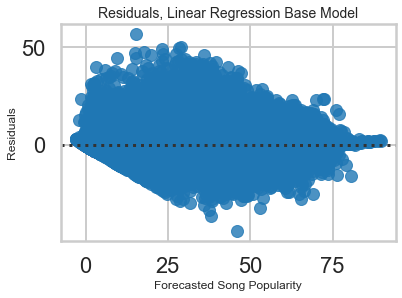

In [12]:
#lets look at the residuals
sns.residplot(x = y_te_pred, y = y_test - y_te_pred)
plt.title('Residuals, Linear Regression Base Model', size = 14)
plt.ylabel('Residuals', size = 12)
plt.xlabel('Forecasted Song Popularity', size = 12)
plt.show()

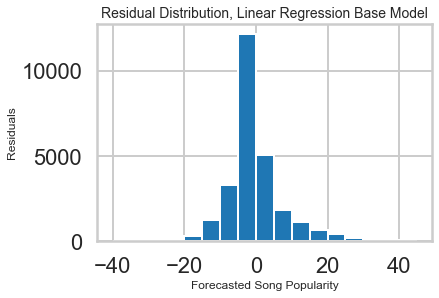

In [13]:
plt.hist(y_test - y_te_pred, bins = np.arange(-40, 50, 5))
plt.title('Residual Distribution, Linear Regression Base Model', size = 14)
plt.ylabel('Residuals', size = 12)
plt.xlabel('Forecasted Song Popularity', size = 12)
plt.show()

The residuals are centered slightly below 0, and there's a decent right skewed distribution: this skew represents songs that are *more* popular than what our model is predicting. Lets try to fine tune the linear model. 

In [14]:
#ridge regression
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha = alpha, fit_intercept = True, random_state = 1)
    ridge.fit(X_tr_scaled, y_train)
    train_error = np.sqrt(mean_squared_error(y_train, ridge.predict(X_tr_scaled)))
    test_error = np.sqrt(mean_squared_error(y_test, ridge.predict(X_te_scaled)))
    print('alpha: {:7} | train MSE: {:5} | test MSE: {:6}'.
          format(alpha,
                 round(train_error,10),
                 round(test_error,10)))
    
    #print('alpha: {:7} | train r2: {:5} | test r2: {:6}'.
     #     format(alpha,
      #           round(r2_score(y_train, ridge.predict(X_tr_scaled)),10),
       #          round(r2_score(y_test, ridge.predict(X_te_scaled)),10)))

alpha:   1e-05 | train MSE: 8.0868151002 | test MSE: 7.952803907
alpha:  0.0001 | train MSE: 8.0868151002 | test MSE: 7.9528039068
alpha:   0.001 | train MSE: 8.0868151002 | test MSE: 7.9528039053
alpha:    0.01 | train MSE: 8.0868151002 | test MSE: 7.9528038903
alpha:     0.1 | train MSE: 8.0868151003 | test MSE: 7.9528037401
alpha:       1 | train MSE: 8.0868151073 | test MSE: 7.952802245
alpha:      10 | train MSE: 8.0868158039 | test MSE: 7.9527879347
alpha:     100 | train MSE: 8.0868844331 | test MSE: 7.9527079107


In [15]:
#verify with GridSearchCV
parameters = {'alpha': alphas}
model = Ridge()
Ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

#fit the grid search
Ridge_reg.fit(X_tr_scaled,y_train)

# best estimator
print(Ridge_reg.best_estimator_)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)


Lets use alpha = .001

In [16]:
#fit with alpha = .01
#ridge = Ridge(alpha = .001)
#ridge.fit(X_tr_scaled, y_train)
# best model
ridge = Ridge_reg.best_estimator_
ridge.fit(X_tr_scaled,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [17]:
#verify with GridSearchCV
parameters = {'alpha': alphas}
model = Lasso()
lasso_reg = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

#fit the grid search
lasso_reg.fit(X_tr_scaled,y_train)

# best estimator
print(lasso_reg.best_estimator_)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [18]:
#fit best lasso
lasso = lasso_reg.best_estimator_
lasso.fit(X_tr_scaled,y_train)

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
print('Base Linear Regression Train Score:      ', lm.score(X_tr_scaled, y_train))
print('Base Linear Regression Test Score: ', lm.score(X_te_scaled, y_test))
print('-'*80)
print('Ridge Regression Train Score:            ', ridge.score(X_tr_scaled, y_train))
print('Ridge Regression Test Score:       ', ridge.score(X_te_scaled, y_test))
print('-'*80)
print('Lasso Regression Train Score:            ', lasso.score(X_tr_scaled, y_train))
print('Lasso Regression Test Score:        ', lasso.score(X_te_scaled, y_test))

Base Linear Regression Train Score:       0.8696329040638551
Base Linear Regression Test Score:  0.8732499569027268
--------------------------------------------------------------------------------
Ridge Regression Train Score:             0.869632903836639
Ridge Regression Test Score:        0.8732500098793184
--------------------------------------------------------------------------------
Lasso Regression Train Score:             0.8696329040598028
Lasso Regression Test Score:         0.8732499674113304


Our Ridge Regression gets us the best score on the test set. Lets move on to random forest. 

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_tr_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [21]:
rf_pred = rf.predict(X_te_scaled)
rf_tr_score = rf.score(X_tr_scaled, y_train)
rf_te_score = rf.score(X_te_scaled, y_test)
rf_mae = np.mean(abs(rf_pred - y_test))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

In [22]:
print('Base Random Forest Train Score:      ', rf_tr_score)
print('Base Random Forest Test Score: ', rf_te_score)
print('Base Random Forest MAE:              ',rf_mae)
print('Base Random Forest RMSE:             ',rf_rmse)

Base Random Forest Train Score:       0.9829180789475191
Base Random Forest Test Score:  0.8811599967332122
Base Random Forest MAE:               5.0065475136352955
Base Random Forest RMSE:              7.700652819235559


So our baseline Random Forest model has already performed better on all metrics vs our linear, ridge, and lasso regression models, with higher train and test scores along with lower MAEs and RMSEs. However it is clearly overfitting on the training set. Lets adjust for hyper parameters. 

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor

#This section of code adapted from code by Kian Ho, Gilles Louppe, and Andreas Meuller
#found in sklearn documentation at:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-
#auto-examples-ensemble-plot-ensemble-oob-py

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

random_state = 42

# Generate a binary classification dataset.
#X, y = make_classification(n_samples = 500, n_features=25,
#                           n_clusters_per_class = 1, n_informative = 15,
#                           random_state = random_state)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features = 'sqrt'",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               oob_score = True,
                               max_features = "sqrt",
                               random_state = random_state,
                               n_jobs = -1)),
    ("RandomForestRegressor, max_features = log2",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               max_features = 'log2',
                               oob_score = True,
                               random_state = random_state,
                               n_jobs = -1)),
    ("RandomForestRegressor, max_features = None",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               max_features = None,
                               oob_score = True,
                               random_state = random_state,
                               n_jobs = -1))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators = i)
        clf.fit(X_tr_scaled, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.title('Random Forest OOB Error Rate by n_estimators')
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc = "upper right")
plt.show()

Automatically created module for IPython interactive environment


/Users/dankang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dankang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


From this we can see using n_estimators of 200-300 would be ideal (we didnt specify these parameters in our baseline model).

In [ ]:
#fine tune our Random Forest Model -- could add max_feat to GridSearchCV
rf_tuned_300 = RandomForestRegressor(n_estimators = 300, max_features = 'log2', n_jobs = -1, random_state = 42, oob_score = True)
rf_tuned_300.fit(X_tr_scaled, y_train)


In [ ]:

rf_pred_300 = rf_tuned_300.predict(X_te_scaled)
rf_tr_score_300 = rf_tuned_300.score(X_tr_scaled, y_train)
rf_te_score_300 = rf_tuned_300.score(X_te_scaled, y_test)
rf_mae_300 = np.mean(abs(rf_pred_300 - y_test))
rf_rmse_300 = np.sqrt(mean_squared_error(y_test, rf_pred_300))

In [ ]:
print('n=300 Random Forest Train Score:      ', rf_tr_score_300)
print('n=300 Random Forest Test Score: ', rf_te_score_300)
print('n=300 Random Forest MAE:              ',rf_mae_300)
print('n=300 Random Forest RMSE:             ',rf_rmse_300)

This improved over our initial random forest model but is still overfitting. We will try to limit max depth and then fine tune further for n_estimators = 400

In [ ]:
rf_tuned_300 = RandomForestRegressor(n_estimators = 300, max_features = 'log2', n_jobs = -1, random_state = 42, oob_score = True, max_depth =14)
rf_tuned_300.fit(X_tr_scaled, y_train)
rf_pred_300 = rf_tuned_300.predict(X_te_scaled)
rf_tr_score_300 = rf_tuned_300.score(X_tr_scaled, y_train)
rf_te_score_300 = rf_tuned_300.score(X_te_scaled, y_test)
rf_mae_300 = np.mean(abs(rf_pred_300 - y_test))
rf_rmse_300 = np.sqrt(mean_squared_error(y_test, rf_pred_300))
print('n=300 Random Forest Train Score:      ', rf_tr_score_300)
print('n=300 Random Forest Test Score: ', rf_te_score_300)
print('n=300 Random Forest MAE:              ',rf_mae_300)
print('n=300 Random Forest RMSE:             ',rf_rmse_300)

after trial and error, we arrive at m = 14 for max_Depth. now fine tune for n_estimators again.

In [ ]:
#fine tune our Random Forest Model
rf_tuned_400 = RandomForestRegressor(n_estimators = 400, max_features = 'log2', n_jobs = -1, random_state = 42, oob_score = True, max_depth=14)
rf_tuned_400.fit(X_tr_scaled, y_train)

rf_pred_400 = rf_tuned_400.predict(X_te_scaled)
rf_tr_score_400 = rf_tuned_400.score(X_tr_scaled, y_train)
rf_te_score_400 = rf_tuned_400.score(X_te_scaled, y_test)
rf_mae_400 = np.mean(abs(rf_pred_400 - y_test))
rf_rmse_400 = np.sqrt(mean_squared_error(y_test, rf_pred_400))

In [ ]:
print('n=400 Random Forest Train Score:      ', rf_tr_score_400)
print('n=400 Random Forest Test Score: ', rf_te_score_400)
print('n=400 Random Forest MAE:              ',rf_mae_400)
print('n=400 Random Forest RMSE:             ',rf_rmse_400)

Sure enough, n = 400 got us the best performance. Lets finally try KN Regressor and then select our final model. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
RMSE_train, RMSE_test = [], []
  
for i in range(5,101,5):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train,y_train)
  y_train_pred = knn.predict(X_tr_scaled)
  knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE_train.append(knn_train_rmse.round(5))
  y_test_pred = knn.predict(X_te_scaled)
  knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE_test.append(knn_test_rmse.round(5))

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(5, 101, 5)
ax = sns.lineplot(x=x, y=RMSE_train)
sns.lineplot(x=x, y=RMSE_test, ax=ax)
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Neighbors')
ax.set_ylabel('RMSE')
ax.set_xticks(np.arange(5,101,5))
ax.set_title('KNN with 10 <= n-neighbors < 100', c='b', fontdict={'c':'b', 'fontsize':16, 'weight':'bold'})
plt.show()

In [ ]:
RMSE_train, RMSE_test = [], []
  
for i in range(100,251,5):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train,y_train)
  y_train_pred = knn.predict(X_tr_scaled)
  knn_train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE_train.append(knn_train_rmse.round(5))
  y_test_pred = knn.predict(X_te_scaled)
  knn_test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE_test.append(knn_test_rmse.round(5))

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(100, 251, 5)
ax = sns.lineplot(x=x, y=RMSE_train)
sns.lineplot(x=x, y=RMSE_test, ax=ax)
ax.legend(labels=['RMSE_train', 'RMSE_test'])
ax.set_xlabel('Neighbors')
ax.set_ylabel('RMSE')
ax.set_xticks(np.arange(100,201,5))
ax.set_title('KNN with 100 <= n-neighbors < 250', c='b', fontdict={'c':'b', 'fontsize':16, 'weight':'bold'})
plt.show()

In both instances the RMSE is way too high. We will go with with our Random Forest Model. 

In [ ]:
ax = sns.scatterplot(x=y_test, y=rf_pred_400)
ax.plot(y_train, y_train, 'b')
ax.set_ylabel('popularity prediction')
plt.show()

In [ ]:
print('Final Random Forest Train Score:      ', rf_tr_score_400)
print('Final Random Forest Test Score: ', rf_te_score_400)
print('Final Random Forest MAE:              ',rf_mae_400)
print('Final Random Forest RMSE:             ',rf_rmse_400)